## We importe the data and the libraries

In [ ]:
pip install --upgrade tensorflow

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [635]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import matplotlib.pyplot as plt #plots
import matplotlib.pyplot as plt
import math
from array import array
import csv

In [636]:
import datetime
from datetime import datetime
import time

In [637]:
import tensorflow as tf
import keras as keras #keras package for neural networks
from keras.layers import Dense #dense layers
from keras.layers import LSTM #LSTM layers
from keras.layers import Dropout #Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model #plot network's structure
from keras.models import Sequential

In [638]:
#https://fred.stlouisfed.org/
#Pour fusionner les données récupérées sur le site de la FRED, nous avons utilisé le fichier R nommé dataviz6columns present dans le fichier zip
dataUS = pd.read_csv('/content/dfmacrodata.csv', sep = ',')
dataUS

,mdate,infUS,intrateUS,M2US,urateUS,RERUS,realWUS
1,1991-01-01,0.056471,0.0691,0.038177,0.064,-0.053048,-0.024693
2,1991-02-01,0.053125,0.0625,0.039412,0.066,-0.052432,-0.023451
3,1991-03-01,0.048212,0.0612,0.041315,0.068,-0.065464,-0.014615
4,1991-04-01,0.048099,0.0591,0.040855,0.067,-0.045947,-0.015619
5,1991-05-01,0.050349,0.0578,0.044492,0.069,-0.034684,-0.019956
...,...,...,...,...,...,...,...
345,2019-09-01,0.017273,0.0204,0.055591,0.035,0.025205,0.020281
346,2019-10-01,0.017571,0.0183,0.064357,0.036,0.024980,0.017647
347,2019-11-01,0.020308,0.0155,0.070800,0.035,0.012783,0.012173
348,2019-12-01,0.022617,0.0155,0.066879,0.035,-0.000294,0.010702


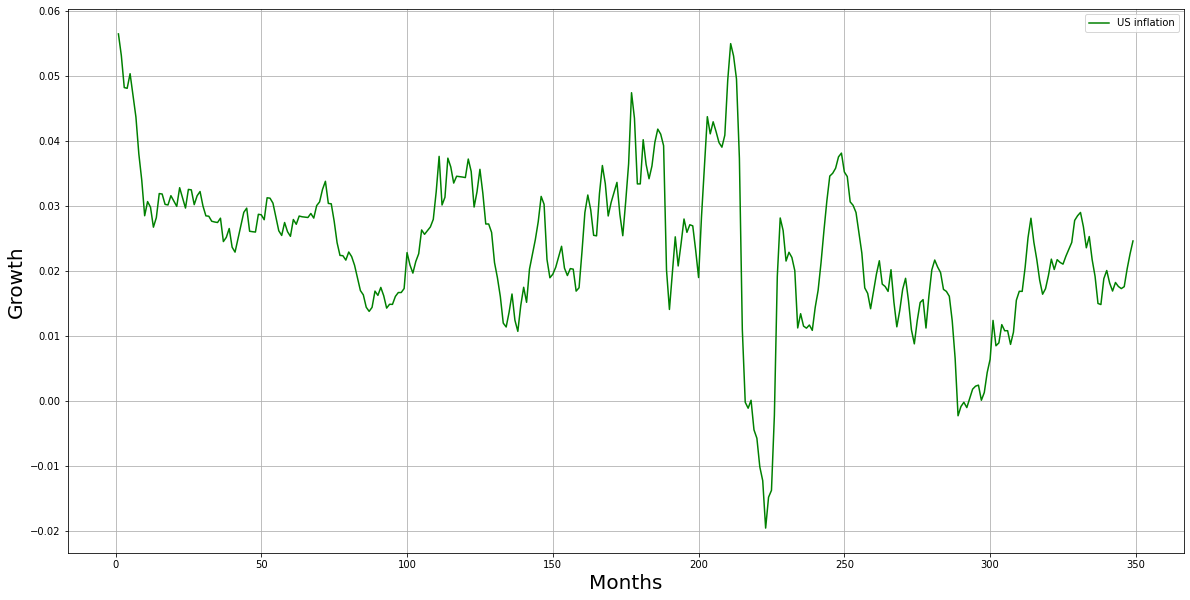

In [639]:
plt.plot(dataUS['infUS'],label='US inflation', color= 'green')
plt.xlabel('Months', size=20)
plt.ylabel('Growth', size=20)
plt.legend()
plt.grid()
#plt.title('US inflation', size=30)
plt.show()

## We do the Neural Network with the data imported above

#### We split the data into training sets (1991-2015), validation sets (2015-2018) and test set (2018) to predict 2019

In [640]:
#U.S. inflation rate for 2020 was 1.23%, a 0.58% decline from 2019.
#U.S. inflation rate for 2019 was 1.81%, a 0.63% decline from 2018.
#U.S. inflation rate for 2018 was 2.44%, a 0.31% increase from 2017.
#U.S. inflation rate for 2017 was 2.13%, a 0.87% increase from 2016.

dataUS['mdate']= pd.to_datetime(dataUS.mdate)
print(dataUS.dtypes)
dataUS.head()

mdate        datetime64[ns]
infUS               float64
intrateUS           float64
M2US                float64
urateUS             float64
RERUS               float64
realWUS             float64
dtype: object


,mdate,infUS,intrateUS,M2US,urateUS,RERUS,realWUS
1,1991-01-01,0.056471,0.0691,0.038177,0.064,-0.053048,-0.024693
2,1991-02-01,0.053125,0.0625,0.039412,0.066,-0.052432,-0.023451
3,1991-03-01,0.048212,0.0612,0.041315,0.068,-0.065464,-0.014615
4,1991-04-01,0.048099,0.0591,0.040855,0.067,-0.045947,-0.015619
5,1991-05-01,0.050349,0.0578,0.044492,0.069,-0.034684,-0.019956


In [641]:
ts2019= pd.to_datetime('2019-01-01')
ts2015= pd.to_datetime('2015-01-01')
ts1519= (dataUS['mdate']>= ts2015)&(dataUS['mdate']<= ts2019)
ts1519[330:340]

331     True
332     True
333     True
334     True
335     True
336     True
337     True
338    False
339    False
340    False
Name: mdate, dtype: bool

In [642]:
#inputs TRAINING PHASE
in_inf = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['infUS']]) 
in_int = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['intrateUS']])
in_M2  = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['M2US']])
in_u   = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['urateUS']])
in_rer = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['RERUS']])
in_rw  = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['realWUS']])

In [643]:
#VALIDATION PHASE
valin_inf = np.array(dataUS.loc[ts1519, ['infUS']])
valin_int = np.array(dataUS.loc[ts1519, ['intrateUS']])
valin_M2  = np.array(dataUS.loc[ts1519, ['M2US']])
valin_u   = np.array(dataUS.loc[ts1519, ['urateUS']])
valin_rer = np.array(dataUS.loc[ts1519, ['RERUS']])
valin_rw  = np.array(dataUS.loc[ts1519, ['realWUS']])
#print(intvalin_inf.dtypes)       
len(valin_u)

49

In [644]:
#output
out_inf = np.array(dataUS.loc[dataUS.mdate <= ts2015, ['infUS']])

valout_inf = np.array(dataUS.loc[ts1519, ['infUS']])

In [645]:
#reshape to [rows, columns]
in_inf = in_inf.reshape((len(in_inf), 1))
in_int = in_int.reshape((len(in_int), 1))
in_M2  = in_M2.reshape((len(in_M2), 1))
in_u   = in_u.reshape((len(in_u), 1))
in_rer = in_rer.reshape((len(in_rer), 1))
in_rw  = in_rw.reshape((len(in_rw), 1))

valin_inf = valin_inf.reshape((len(valin_inf), 1))
valin_int = valin_int.reshape((len(valin_int), 1))
valin_M2  = valin_M2.reshape((len(valin_M2), 1))
valin_u   = valin_u.reshape((len(valin_u), 1))
valin_rer = valin_rer.reshape((len(valin_rer), 1))
valin_rw  = valin_rw.reshape((len(valin_rw), 1))


out_inf = out_inf.reshape((len(out_inf), 1))
valout_inf = valout_inf.reshape((len(valout_inf), 1))

In [646]:
#The following function splits a multivariate sequence into samples:

def split(seq, nstepsin, nstepsout):
    X= list()
    Y= list()
    for i in range(len(seq)):
        endix= i + nstepsin
        outendix= endix + nstepsout - 1
    
        if outendix > len(seq):
            break
    
        seqx= seq[i:endix,:-1] #j'avais mis -2 pour enlever la date
        seqy= seq[endix -1: outendix, -1] #j'avais mis -2 pour enlever la date
        X.append(seqx)
        Y.append(seqy)
    
    return np.array(X), np.array(Y)
    

In [647]:
#stack columns horizontally
dataset = np.hstack((in_inf, in_int, in_M2, in_u, in_rer, in_rw, out_inf))
valset = np.hstack((valin_inf, valin_int, valin_M2, valin_u, valin_rer, valin_rw, valout_inf))                        
dataset.shape

(289, 7)

In [648]:
#use of the split function
nstepsin, nstepsout = 12, 12 #use 12 observations to predict next 12
X, y = split(dataset, nstepsin, nstepsout)
print(X.shape, y.shape) #shape of input and output = (267, 12, 7) and (267, 12)
valX, valy = split(valset, nstepsin, nstepsout)

(267, 12, 6) (267, 12)


In [649]:
#TEST PHASE
ts2018= pd.to_datetime('2018-01-01')
ts2020= pd.to_datetime('2020-01-01')
ts1819= (dataUS['mdate']> ts2018)&(dataUS['mdate']<= ts2019)
ts1920= (dataUS['mdate']> ts2019)&(dataUS['mdate']<= ts2020)
x_inf = np.array(dataUS.loc[ts1819, ['infUS']]) 
x_int = np.array(dataUS.loc[ts1819, ['intrateUS']])
x_M2  = np.array(dataUS.loc[ts1819, ['M2US']])
x_u   = np.array(dataUS.loc[ts1819, ['urateUS']])
x_rer = np.array(dataUS.loc[ts1819, ['RERUS']])
x_rw  = np.array(dataUS.loc[ts1819, ['realWUS']])
x_rw

array([[5.61349594e-03],
       [4.94587548e-03],
       [4.75237450e-03],
       [1.28535543e-03],
       [4.75392953e-05],
       [1.76778962e-03],
       [2.94973275e-03],
       [8.90982781e-03],
       [9.35262701e-03],
       [1.36979554e-02],
       [1.43898834e-02],
       [2.02845209e-02]])

In [650]:
nfeatures = X.shape[2]
nfeatures

6

In [651]:
#Network: cf tp10 
#for the activation function(that will determine the output layer), we choose the hyperbolic tangent because we are doing a regression with bounded outputs
#LTSM: Long Short-Term Memory cells 
#It is a type of recurrent neural network. The advantage is that output could become input.
#As a matter of fact, there is a cell in the node named 'state'. This cell is devided in 3 parts. The forget gate, where we decided what can be forgotten, (0 or 1)
#the input gate, where we choose what new info should be added (0 or 1) and the output gate in which we say whoch part should be output (0 or 1).
network = Sequential() 
network.add(LSTM(100, activation = 'relu', return_sequences = True, input_shape = (nstepsin, nfeatures)))

In [652]:
# dropout is when you go form one stage to the other the program droups out a certain percentage of data. 
# For instance if we set the dropout equa to 0.5, half of the data is dropped
network.add(LSTM(100, dropout = 0.25,recurrent_dropout = 0.25, activation = 'relu'))

#Never take a dropout larger than 0.3 unless you have millions of datapoints

In [653]:
#here we add new layers to the neural network 
network.add(Dense(100, activation = 'relu'))
network.add(Dense(100, activation = 'relu'))#
network.add(Dense(100, activation = 'relu'))#
network.add(Dense(25, activation = 'relu'))
network.add(Dense(nstepsout))
network

In [654]:
#compile model
#First, we define the learning rate at 0.0001.
network.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'mse')

In [655]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min',min_delta = 0.01,patience = 200,verbose = 1)
es
#early stopping stop training before the model is suffering from overfitting
#Every end of epoch, we check and stop training if validation accuracy decrease steadily, while train accuracy increases. 

In [656]:
#fit
#We define the epoch equal to 1000. 
#As seen in lesson, epoch is the number of time the learning algorithm works through the entire training set. 
#Verbose: By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.
#Batchsize: similar to epoch: nb of training examples utilized in one iteration
fit = network.fit(X, y, validation_data = (valX, valy), epochs = 1000, verbose = 1,callbacks = [es]
                  ,batch_size=20)
fit

Epoch 1/1000
14/14 [==============================] - 10s 140ms/step - loss: 6.4516e-04 - val_loss: 2.9802e-04
Epoch 2/1000
14/14 [==============================] - 1s 73ms/step - loss: 4.7036e-04 - val_loss: 1.9432e-04
Epoch 3/1000
14/14 [==============================] - 1s 81ms/step - loss: 3.3981e-04 - val_loss: 1.3970e-04
Epoch 4/1000
14/14 [==============================] - 1s 85ms/step - loss: 2.6321e-04 - val_loss: 1.1368e-04
Epoch 5/1000
14/14 [==============================] - 1s 77ms/step - loss: 2.1796e-04 - val_loss: 8.6502e-05
Epoch 6/1000
14/14 [==============================] - 1s 77ms/step - loss: 1.8474e-04 - val_loss: 6.8361e-05
Epoch 7/1000
14/14 [==============================] - 1s 80ms/step - loss: 1.6199e-04 - val_loss: 5.4834e-05
Epoch 8/1000
14/14 [==============================] - 1s 88ms/step - loss: 1.4521e-04 - val_loss: 4.4160e-05
Epoch 9/1000
14/14 [==============================] - 1s 91ms/step - loss: 1.3293e-04 - val_loss: 3.5739e-05
Epoch 10/1000
14/

In [657]:
#prediction
x_input = np.array([x_inf, x_int, x_M2, x_u, x_rer, x_rw])
x_input = x_input.reshape((1, nstepsin, nfeatures))

yhat = network.predict(x_input, verbose = 1) #as in exercise 10, we use the .predict function to test our model and see if he is efficient 
print(yhat)

1/1 [==============================] - 0s 416ms/step
[[0.00879259 0.00808396 0.00755025 0.00964519 0.01228544 0.01331017
  0.01277346 0.01523806 0.01683902 0.02014073 0.02199563 0.0201785 ]]


In [658]:
network.summary()
#LTSM with 12 neurones

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 12, 100)           42800     
                                                                 
 lstm_23 (LSTM)              (None, 100)               80400     
                                                                 
 dense_55 (Dense)            (None, 100)               10100     
                                                                 
 dense_56 (Dense)            (None, 100)               10100     
                                                                 
 dense_57 (Dense)            (None, 100)               10100     
                                                                 
 dense_58 (Dense)            (None, 25)                2525      
                                                                 
 dense_59 (Dense)            (None, 12)              

<function matplotlib.pyplot.show>

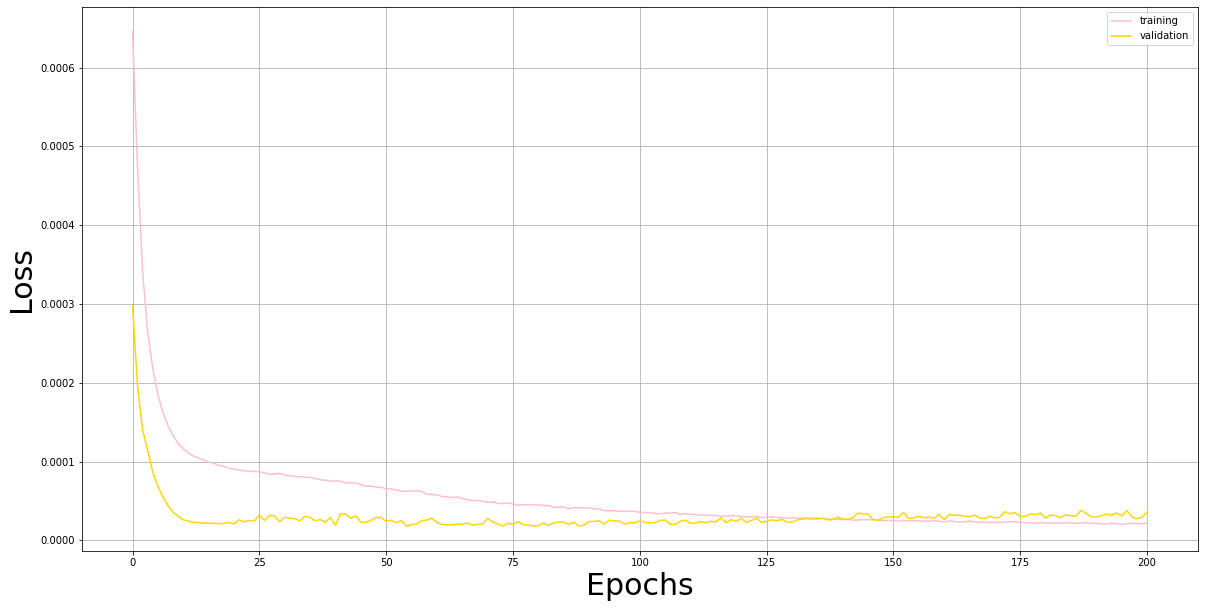

In [659]:
plt.plot(fit.history['loss'], label = 'training', color = 'pink')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Epochs', size=30)
plt.ylabel('Loss', size=30)
plt.legend()
plt.grid()
plt.show
#here the validation loss is first below and then above the training loss
#The training loss should be lower
#here the validation is lower at the beginning bc during the training process it uses dropout so fourty %
#of the neurons are set to zero at each time
#But during the testing, all the neurons are used
#Thus, model during testing is more robust
#Both training and validation errors seems small. We have done a good choice of dropout

#here, we don't have overfitting

In [660]:
yhat.T
index=pd.date_range('01/01/2019',periods=12,freq='M')
index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

In [661]:
yhat

array([[0.00879259, 0.00808396, 0.00755025, 0.00964519, 0.01228544,
        0.01331017, 0.01277346, 0.01523806, 0.01683902, 0.02014073,
        0.02199563, 0.0201785 ]], dtype=float32)

In [662]:
predicted = pd.DataFrame(yhat.T, index)
predicted

,0
2019-01-31,0.008793
2019-02-28,0.008084
2019-03-31,0.007550
2019-04-30,0.009645
2019-05-31,0.012285
2019-06-30,0.013310
2019-07-31,0.012773
2019-08-31,0.015238
2019-09-30,0.016839
2019-10-31,0.020141


In [663]:
ts2019= pd.to_datetime('2019-01-01')
ts2020= pd.to_datetime('2020-01-01')
ts1920= (dataUS['mdate']> ts2019)&(dataUS['mdate']<= ts2020)

In [664]:
observed = dataUS.loc[ts1920, ['mdate','infUS']]
observed= observed.set_index('mdate')
observed.head()

,infUS
mdate,
2019-02-01,0.014817
2019-03-01,0.018800
2019-04-01,0.020056
2019-05-01,0.018128
2019-06-01,0.016896


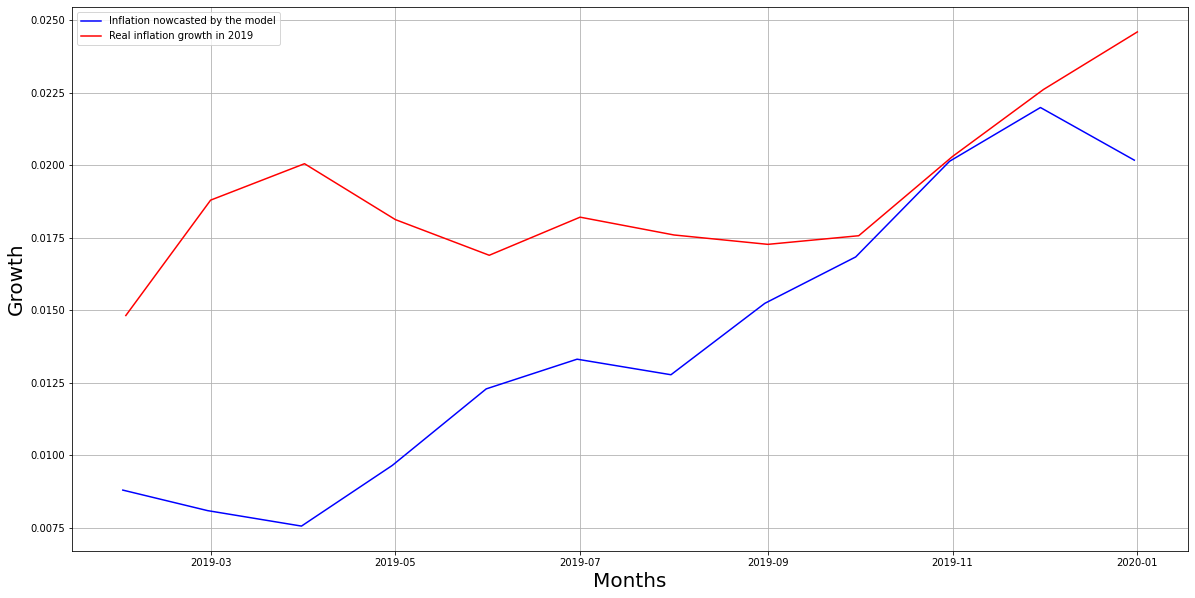

In [665]:
#plt.scatter(index,predicted, label='predicted', color='Blue')
plt.plot(predicted, label='Inflation nowcasted by the model', color='Blue')
#plt.ylim(bottom=0.005, top=0.015)
#plt.xlabel('Months')
#plt.ylabel('Predicted inflation')
plt.plot(observed['infUS'], label='Real inflation growth in 2019 ', color='Red')
#plt.ylim(bottom=0.02, top=0.03)
plt.xlabel('Months', size=20)
plt.ylabel('Growth', size=20)
#plt.show()
plt.legend()
#plt.title('Observed vs Predicted 1', size=30)
plt.grid()
plt.show()
#PB: the scale of testing (1 year) is still a bit small here

In [666]:
#absolute error in %
model_error = (np.abs(np.array(predicted) - np.array(observed)))*100
len(model_error)
model_error

array([[0.60246558],
       [1.0715547 ],
       [1.25060396],
       [0.84823264],
       [0.46110017],
       [0.49014496],
       [0.48234324],
       [0.20352397],
       [0.07318327],
       [0.01674387],
       [0.06215838],
       [0.44264011]])

In [667]:
#relative error (avant j'avais divisé par observed)
model_error1 = ((np.abs(np.array(predicted)) - np.array(observed))/np.array(observed))*100
len(model_error1)
model_error1

array([[-40.65974368],
       [-56.99908219],
       [-62.35470987],
       [-46.79255041],
       [-27.2897837 ],
       [-26.91385241],
       [-27.41070597],
       [-11.78257582],
       [ -4.1650389 ],
       [ -0.82448959],
       [ -2.74827764],
       [-17.98991456]])

In [668]:
index= pd.date_range('02/01/2019',periods=12,freq='M')
index

DatetimeIndex(['2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31'],
              dtype='datetime64[ns]', freq='M')

In [669]:
model_error = pd.DataFrame(model_error, index)
model_error1 = pd.DataFrame(model_error1, index)
model_error1.head()

,0
2019-02-28,-40.659744
2019-03-31,-56.999082
2019-04-30,-62.354710
2019-05-31,-46.792550
2019-06-30,-27.289784


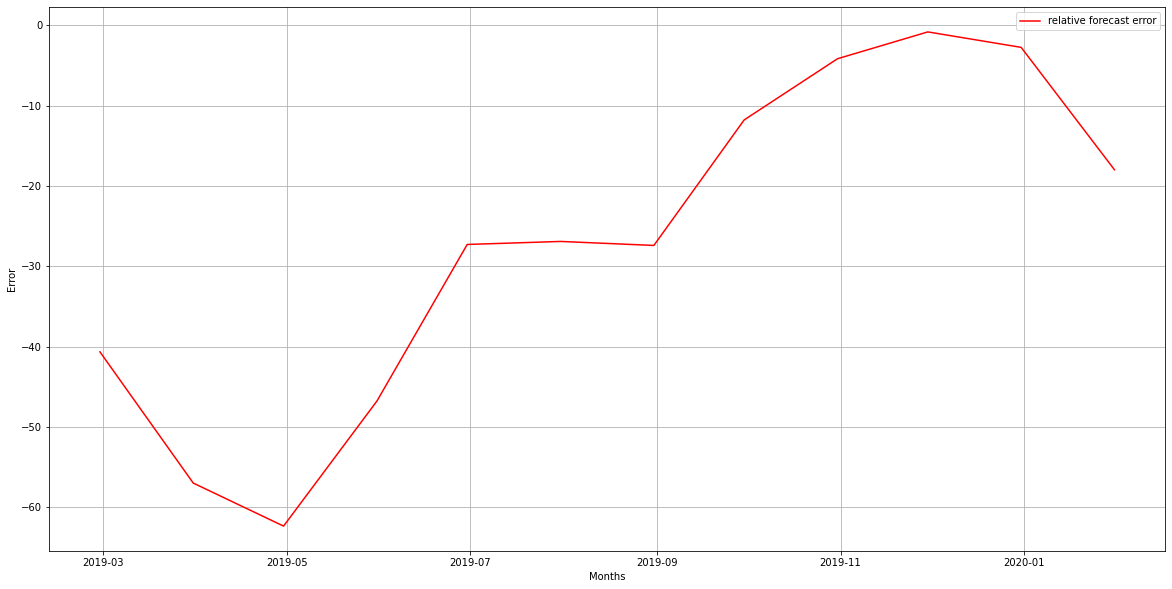

In [670]:
model_error.columns = ['absolute forecast error']
model_error1.columns = ['relative forecast error']
#plt.xlabel('Month')
#plt.ylabel('Error')
#model_error.plot(color = 'purple')
#model_error1.plot(color= 'red')
#plt.plot(model_error , label='absolute forecast error', color = 'purple')
plt.plot(model_error1 , label='relative forecast error', color= 'red')
plt.xlabel('Months')
plt.ylabel('Error')
plt.legend()
plt.grid()
#plt.title('Forecast Error')
plt.show()

In [671]:
abs(model_error.mean())
#divide error by realisation 

absolute forecast error    0.500391
dtype: float64

In [672]:
abs(model_error1.mean())

relative forecast error    27.160894
dtype: float64

In [673]:
#each month, I have an error of the order of 10^-5 on the future prediction
observed.describe()
# standard deviation of the real inflation is 0.0013 in 2019. The variance is equal to 1.62*10^-6

,infUS
count,12.000000
mean,0.018907
std,0.002655
min,0.014817
25%,0.017496
50%,0.018170
75%,0.020119
max,0.024605


In [674]:
#print('The bias term is', network.layers[0].get_weights()[0][0][0],'and the network weight is', network.layers[0].get_weights()[1][0])

## Real Inflation

In [675]:
#dataUS10 = pd.read_excel('/content/US_Infl10.xlsx')
#print(dataUS10.dtypes)
#datadata= dataUS[['mdate','infUS']]
#datadata.head()

In [676]:
#need to import a new file to have the CPI index
dataUS100 = pd.read_excel('/content/US_InflFI.xlsx')
print(dataUS100.dtypes)

observation_date    datetime64[ns]
CPILFESL                   float64
INFL                       float64
CPILFESL(n-1)              float64
dtype: object


In [677]:
dataUS100['observation_date']= pd.to_datetime(dataUS100.observation_date)
dataUS100

,observation_date,CPILFESL,INFL,CPILFESL(n-1)
0,1947-01-01,21.480,NaN,NaN
1,1947-02-01,21.620,NaN,NaN
2,1947-03-01,22.000,NaN,NaN
3,1947-04-01,22.000,NaN,NaN
4,1947-05-01,21.950,NaN,NaN
...,...,...,...,...
900,2022-01-01,281.933,0.075259,NaN
901,2022-02-01,284.182,0.079120,NaN
902,2022-03-01,287.708,0.085576,NaN
903,2022-04-01,288.663,0.082241,NaN


In [678]:
predicted['date']= dataUS100['observation_date']
predicted['date']= ['2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01','2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01','2020-01-01']
predicted['date']= pd.to_datetime(predicted.date)
#predicted.rename(columns= {'0': 'yhat'}, inplace= True)
predicted.columns = ['yhat', 'date']
predicted

,yhat,date
2019-01-31,0.008793,2019-02-01
2019-02-28,0.008084,2019-03-01
2019-03-31,0.007550,2019-04-01
2019-04-30,0.009645,2019-05-01
2019-05-31,0.012285,2019-06-01
2019-06-30,0.013310,2019-07-01
2019-07-31,0.012773,2019-08-01
2019-08-31,0.015238,2019-09-01
2019-09-30,0.016839,2019-10-01
2019-10-31,0.020141,2019-11-01


In [679]:
#dataUS10 = dataUS10.set_index('observation_date')
#dataUS10
ts1920_100= (dataUS100['observation_date']> ts2019)&(dataUS100['observation_date']<= ts2020)
ts1819_100= (dataUS100['observation_date']> ts2018)&(dataUS100['observation_date']<= ts2019)

In [680]:
observed100 = dataUS100.loc[ts1920_100, ['observation_date','CPILFESL']]
observed100 = observed100.set_index('observation_date')
observed100

,CPILFESL
observation_date,
2019-02-01,253.135
2019-03-01,254.273
2019-04-01,255.163
2019-05-01,255.325
2019-06-01,255.361
2019-07-01,255.900
2019-08-01,256.179
2019-09-01,256.596
2019-10-01,257.305


In [681]:
predicted100 = dataUS100.loc[ts1920_100]
#observed10 = observed10.set_index('observation_date')
predicted100

,observation_date,CPILFESL,INFL,CPILFESL(n-1)
865,2019-02-01,253.135,0.014817,249.439
866,2019-03-01,254.273,0.018800,249.581
867,2019-04-01,255.163,0.020056,250.146
868,2019-05-01,255.325,0.018128,250.779
869,2019-06-01,255.361,0.016896,251.118
870,2019-07-01,255.900,0.018212,251.323
871,2019-08-01,256.179,0.017597,251.749
872,2019-09-01,256.596,0.017273,252.239
873,2019-10-01,257.305,0.017571,252.862
874,2019-11-01,257.788,0.020308,252.657


In [682]:
predicted1000= pd.merge(
    predicted100,
    predicted,
    how="inner",
    #on= 'observation_date',
    left_on= 'observation_date',
    right_on= 'date'
)
#predicted100= predicted10.merge()
predicted1000

,observation_date,CPILFESL,INFL,CPILFESL(n-1),yhat,date
0,2019-02-01,253.135,0.014817,249.439,0.008793,2019-02-01
1,2019-03-01,254.273,0.018800,249.581,0.008084,2019-03-01
2,2019-04-01,255.163,0.020056,250.146,0.007550,2019-04-01
3,2019-05-01,255.325,0.018128,250.779,0.009645,2019-05-01
4,2019-06-01,255.361,0.016896,251.118,0.012285,2019-06-01
5,2019-07-01,255.900,0.018212,251.323,0.013310,2019-07-01
6,2019-08-01,256.179,0.017597,251.749,0.012773,2019-08-01
7,2019-09-01,256.596,0.017273,252.239,0.015238,2019-09-01
8,2019-10-01,257.305,0.017571,252.862,0.016839,2019-10-01
9,2019-11-01,257.788,0.020308,252.657,0.020141,2019-11-01


In [683]:
predicted1000['predicted']= (predicted1000['yhat']+1) * predicted1000['CPILFESL(n-1)'] 
#predicted10['predicted'] = predicted10['predictedtemp']* (predicted10['CPILFESL(n-1)'])
predicted1000 = predicted1000.set_index('observation_date')
predicted1000.head()

,CPILFESL,INFL,CPILFESL(n-1),yhat,date,predicted
observation_date,,,,,,
2019-02-01,253.135,0.014817,249.439,0.008793,2019-02-01,251.632227
2019-03-01,254.273,0.018800,249.581,0.008084,2019-03-01,251.598598
2019-04-01,255.163,0.020056,250.146,0.007550,2019-04-01,252.034662
2019-05-01,255.325,0.018128,250.779,0.009645,2019-05-01,253.197820
2019-06-01,255.361,0.016896,251.118,0.012285,2019-06-01,254.203103


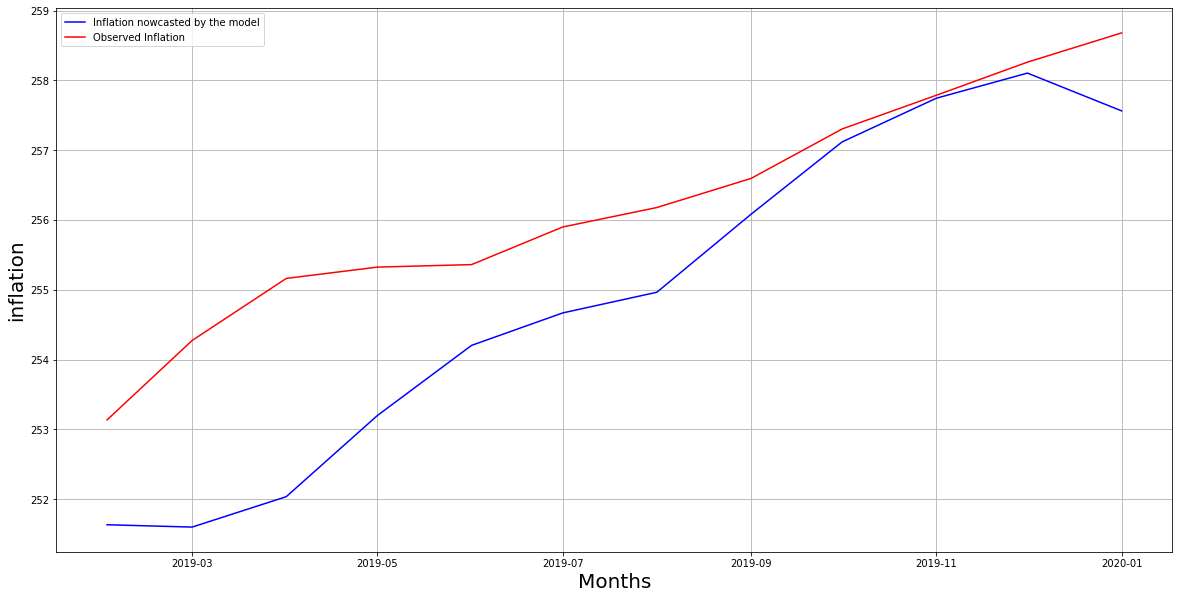

In [684]:
#plt.scatter(index,predicted, label='predicted', color='Blue')
plt.plot(predicted1000['predicted'], label='Inflation nowcasted by the model', color='Blue')
#plt.ylim(bottom=0.005, top=0.015)
#plt.xlabel('Months')
#plt.ylabel('Predicted inflation')
plt.plot(observed100['CPILFESL'], label='Observed Inflation ', color='Red')
#plt.ylim(bottom=0.02, top=0.03)
plt.xlabel('Months', size=20)
plt.ylabel('inflation', size=20)
#plt.show()
plt.legend()
#plt.title('Observed vs Predicted 2', size=30)
plt.grid()
plt.show()
#PB: the scale of testing (1 year) is still a bit small here

In [685]:
np.array(observed100['CPILFESL'])

array([253.135, 254.273, 255.163, 255.325, 255.361, 255.9  , 256.179,
       256.596, 257.305, 257.788, 258.263, 258.682])

In [686]:
np.array(predicted1000['predicted'])

array([251.63222702, 251.59859772, 252.03466223, 253.19781953,
       254.2031029 , 254.66815789, 254.96471932, 256.08262965,
       257.11995015, 257.74570579, 258.10602685, 257.56448014])

In [687]:
#relative error (avant j'avais divisé par observed)
model_error2 = ((np.abs(np.array(predicted1000['predicted'])) - np.array(observed100['CPILFESL']))/np.array(observed100['CPILFESL']))*100
len(model_error2)
model_error2

array([-0.59366464, -1.05178382, -1.22601544, -0.83312659, -0.45343537,
       -0.48137636, -0.47399696, -0.20006951, -0.07191848, -0.01640659,
       -0.06078035, -0.43200526])

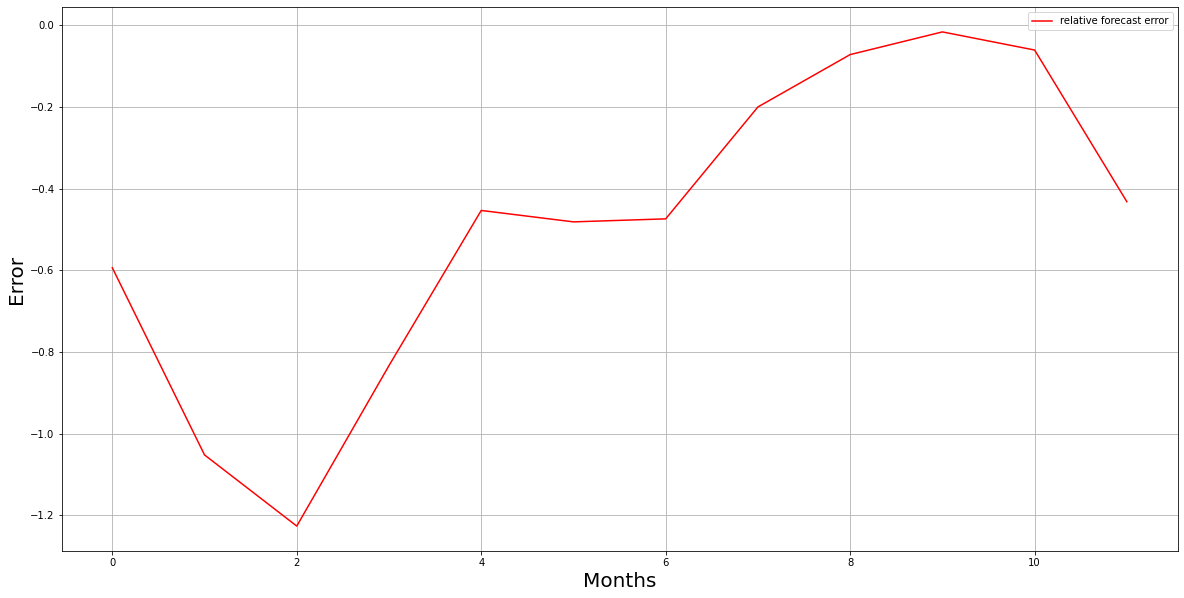

In [688]:
#model_error2.columns = ['relative forecast error']
#plt.xlabel('Month')
#plt.ylabel('Error')
#model_error.plot(color = 'purple')
#model_error1.plot(color= 'red')
#plt.plot(model_error , label='absolute forecast error', color = 'purple')
plt.plot(model_error2 , label='relative forecast error', color= 'red')
plt.xlabel('Months', size=20)
plt.ylabel('Error', size=20)
plt.legend()
plt.grid()
#plt.title('Forecast Error', size=30)
plt.show()

In [689]:
abs(model_error2.mean())

0.49121494761329765

# DRAFT

In [690]:
#DATAUS1 = inflationUS.merge(right= interestrateUS, left_on='DATE', right_on='observation_date', how='inner')
#inner intersection SI il manque des données sur une ligne on enlève
#outer ca met NA sur les lignes ou y a pas d'info

#pd.merge_asof(inflationUS, interestrateUS, left_on='DATE', right_on='observation_date')

#DATAUS1.drop(columns='observation_date')
#DATAUS1

#DATAUS2 = DATAUS1.merge(right= unemploymentrateUS, left_on='DATE', right_on='observation_date', how='inner')

#DATAUS3 = DATAUS2.merge(right= wagesus, left_on='DATE', right_on='observation_date', how='inner')
#DATAUS3

#DATAUS4 = DATAUS3.merge(right= exchangerateRERUS, left_on='DATE', right_on='observation_date', how='inner')
#DATAUS4.replace('FPCPITOTLZGUSA','inflationUS')
#DATAUS4

#DATAUS4.dtypes

In [522]:
#valout_inflationUSA.drop('DATE', axis=1, inplace=True)
#valout_inflationUS = np.array(valout_inflationUSA)

#out_inflationUS[0]

In [523]:
#in_inflationUS = in_inflationUS.reshape((len(in_inflationUS),1))
#in_inflationUS[0]

In [ ]:
#reshape
#l'objectif ici c'est de tej les dates pour pouvoir reshape avec que les datas
#in_inflationUS = in_inflationUS.reshape((len(in_inflationUS),1))
#in_interestrateUS = in_interestrateUS.reshape((len(in_interestrateUS),1))
#in_unemploymentrateUS = in_unemploymentrateUS.reshape((len(in_unemploymentrateUS),1))
#in_wagesUS = in_wagesUS.reshape((len(in_wagesUS),1))
#in_exchangerateUS = in_exchangerateUS.reshape((len(in_exchangerateUS),1))

#valin_inflationUS = valin_inflationUS.reshape((len(valin_inflationUS),1))
#valin_interestrateUS = valin_interestrateUS.reshape((len(valin_interestrateUS),1))
#valin_unemploymentrateUS = valin_unemploymentrateUS.reshape((len(valin_unemploymentrateUS),1))
#valin_wagesUS = valin_wagesUS.reshape((len(valin_wagesUS),1))
#valin_exchangerateUS = valin_exchangerateUS.reshape((len(valin_exchangerateUS),1))

#out_inflationUS= out_inflationUS.reshape((len(out_inflationUS),1))
#valout_inflationUS= valout_inflationUS.reshape((len(valout_inflationUS),1))

In [ ]:
#in_interestrateUS[0]

In [ ]:
#stack data (équivalent de merge mais pour des array et pas des dataframe)
#dataset = np.hstack((in_inflationUS, in_interestrateUS, in_unemploymentrateUS, in_wagesUS, in_exchangerateUS, out_inflationUS))

In [ ]:
#dataset[0]

In [ ]:
#valout_inflationUS[0]

In [ ]:
#valset= np.hstack((valin_inflationUS, valin_interestrateUS, valin_unemploymentrateUS, valin_wagesUS, valin_exchangerateUS, valout_inflationUS))
#valset[0]

In [ ]:
#number of steps (We take 12 observations to predict next 12)
#nstepsin=12
#nstepsout=12

#X,Y= split(dataset,nstepsin,nstepsout)
#X, c'est 230 matrices 12*11. Matrice 12*11 car en enlève la dernière colonne qui sont les outputs
#print(X.shape,Y.shape)
#Je devrais avoir X.shape= (230, 12, 5) (5= 6-1) et Y.shape= (230, 12)
#X[0][0]

In [ ]:
#Y[0]

In [ ]:
#valX, valY= split(valset, nstepsin, nstepsout)
#print(valX,valY)
#print(valX.shape,valY.shape)

In [ ]:
#out of sample inputs

#x_inflationUSA = inflationUS[(inflationUS["DATE"] > '2018-01-01') & (inflationUS["DATE"] <= '2019-01-01')]
#x_inflationUSA.drop('DATE', axis=1, inplace=True)
#x_interestrateUSA = interestrateUS[(interestrateUS["observation_date"] > '2018-01-01') & (interestrateUS["observation_date"] <= '2019-01-01')]
#x_interestrateUSA.drop('observation_date', axis=1, inplace=True)
#x_unemploymentrateUSA = unemploymentrateUS[(unemploymentrateUS["observation_date"] > '2018-01-01') & (unemploymentrateUS["observation_date"] <= '2019-01-01')]
#x_unemploymentrateUSA.drop('observation_date', axis=1, inplace=True)
#x_wagesUSA = wagesus[(wagesus["observation_date"] > '2018-01-01') & (wagesus["observation_date"] <= '2019-01-01')]
#x_wagesUSA.drop('observation_date', axis=1, inplace=True)
#x_exchangerateUSA = exchangerateRERUS[(exchangerateRERUS["observation_date"] > '2018-01-01') & (exchangerateRERUS["observation_date"] <= '2019-01-01')]
#x_exchangerateUSA.drop('observation_date', axis=1, inplace=True)

#x_inflationUS = np.array(x_inflationUSA)
#x_interestrateUS = np.array(x_interestrateUSA)
#x_unemploymentrateUS = np.array(x_unemploymentrateUSA)
#x_wagesUS = np.array(x_wagesUSA)
#x_exchangerateUS = np.array(x_exchangerateUSA)
#x_exchangerateUS

In [ ]:
#le pb est la En fait j'ai 12 elem en ligne et 11 en colonne. Sauf que les 12 elem en ligne c est 5*2 pour input et date et 1*2 pour output et date
#nfeatures= X.shape[2]
#nfeatures


In [ ]:
#[print(i.shape, i.dtype) for i in model.inputs]
#[print(o.shape, o.dtype) for o in model.outputs]
#[print(l.name, l.input_shape, l.dtype) for l in model.layers]

In [ ]:
#fit PB HERE!!!!!

#fit = model.fit(X, 
#          Y, 
#          validation_data = (valX, valY), 
#          epochs = 500, 
#          verbose = 1,
#          callbacks = [es])

#fit = model.fit(X,Y)

In [ ]:
#prediction
#x_input = np.array([x_inflationUS, 
#                 x_interestrateUS, 
#                 x_unemploymentrateUS, 
#                 x_wagesUS, 
#                 x_exchangerateUS])
#x_input

In [ ]:
#PB HERE!!!!!
#x_input = x_input.reshape((1, nstepsin, nfeatures))
#x_input

In [ ]:
#yhat = model.predict(x_input, verbose = 1)
#yhat.shape
#PB sur le Yhat

In [ ]:
#print(model.summary())

In [ ]:
#plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
#plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
#plt.legend()
#plt.show

In [ ]:
#predicted = pd.DataFrame(yhat.T, index=pd.date_range('02/01/2019',periods=12,freq='M'))
#predicted.columns = ['predicted']

#predicted.plot(color = 'Blue')
#plt.show()

In [ ]:
#observed = inflationUS[(inflationUS["DATE"] > '2019-01-01') & (inflationUS["DATE"] <= '2020-01-01')]
#x= observed['DATE']
#y= observed['InflationUS']
#plt.plot(x,y,color='red')
#plt.show()
#plot tout sur le meme graph Juste mettre plt.plot de chaque ici

In [ ]:
#model_error = np.array(predicted) - np.array(observed)
#model_error = pd.DataFrame(model_error, index=pd.date_range('02/01/2019',periods=12,freq='M'))
#model_error.columns = ['forecast error']

#model_error.plot(color = 'yellow')
#plt.show()

In [ ]:
#model_error.mean()

In [ ]:
#predicted10_temp = dataUS10.loc[ts1819_10, ['observation_date','CPILFESL']]
#predicted10_temp = predicted10_temp.set_index('observation_date')
#predicted10_temp
#predicted10_temp['observation_date']= observed10['observation_date']
#predicted10_temp
#predicted10_temp1= dataUS10.loc[ts1920_10, ['observation_date','CPILFESL']]
#predicted10_temp1['CPILFESL']= predicted10_temp['CPILFESL']
#predicted10_temp1
#observed10.multiply(predicted10_temp, axis='CPILFESL', level=None, fill_value=None)
#predicted10_temp['CPILFESL']
#i=0
#predicted10 = (observed10['CPILFESL'] + 1)*predicted10_temp['CPILFESL']
#predicted10